In [1]:
# IMPORTS
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Figures
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import sklearn
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

<div class="alert alert-block alert-info">
<b>HRANalytics corp.</b>

This project focuses on applying  Feature Engineering processes and Evaluation methods to predict absenteeism from the employees in the P&C Policy Issuance operational area at ATSA Insurance Madrid. Our client and Business Owner is the Issuance Manager and her team, who have provided all the required information on the Blueprint document that has been agreed and signed between both parties, and that will be the main guide and input for the development of this task.
<div/>

We will be using the `Abstenteeism at Work` dataset that has been delivered in the BP document. This dataset includes several explanatory variables  (that may/may not relate to the absence from work) collected for 36 different employees. The original version of the dataset can be downloaded <a href="https://archive.ics.uci.edu/ml/datasets/Absenteeism+at+work">HERE</a>.

A categorical variable `Absenteeism` that substitutes the original target variable `Absenteeism.time.in.hours` has been included. This is a binomial feature setting whether individuals are going to be absent more than X (`X=5`) hours in total or not (i.e. if it's going to be a long absence).
In addition, to allow the fair comparison of the results, the dataset has been splitted into training and test. For the test split, we have removed the target variable `Absenteeism` that we will predict using our model.

## Objective
The main goal is to **predict whether or not an individual is going to have a long absence** (`Absenteeism` variable), therefore a binary classification problem.

To that end, different steps must be covered:

- Clean the dataset to allow its further processing. The dataset should be transformed by removing errors, imputing missing values (if present in the dataset) and leaving only those features that are really informative. At this point, it's important to run a basic model (baseline) over the dataset to have an starting point for further processing.
- Use the feature engineering techniques explained in class to construct new features and select the best subset of them: filtering, wrapper and embedded methods. Check if you have improved your model w.r.t. your baseline model.
- Properly apply the evaluation methods and ideas (train, validation, test splitting; cross-validation, choose the proper metric, ..) to understand the real performance of the proposed models, making sure that they will generalize to unseen data (test set). I will use accuracy for evaluate your results, so I recommend you to use the same metric to train your models.

These steps are iterative. You must show with data whether your decisions are working towards a better model or not, to finally make a recommendation on what are the best features and the best model. Think about it as if you had to present this report to the HR manager of the company.

# Useful Functions

In order to facilitate the evaluation of the impact of the different steps, I am going to place the code for creating a baseline model in a function. Now I can call it again and again without having to re-write everything. The only thing that changes from one case to another is the dataset that is used to train the model.


In [2]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes.tolist(), rotation=45)
    plt.yticks(tick_marks, classes.tolist())

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 verticalalignment='center',
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(classes)-0.5, -0.5)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def train_model(X,y, model, show_cm=True, show_fi=False):
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_mat = confusion_matrix(y, y_pred)
    score = accuracy_score(y,y_pred)
    print("Accuracy = {0:.4f}".format(score))
    if show_cm:
        plot_confusion_matrix(conf_mat, y.unique())
        model.fit(X, y)
    if show_fi:
        get_feature_importance(model, X.columns, n_features=25)
    return model, score

def get_feature_importance(clf, features, n_features):
    feature_importance = abs(clf.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)[:n_features]
    pos = np.arange(sorted_idx.shape[0]) + .5

    featfig = plt.figure(figsize=(10,10))
    featfig.suptitle(str(n_features) + " Most important features")
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, feature_importance[sorted_idx], align='center')
    featax.set_yticks(pos)
    featax.set_xticks([])
    featax.set_yticklabels(np.array(features)[sorted_idx], fontsize=15)
    featax.set_xlabel('Relative Feature Importance', fontsize=15)
    plt.show()


# Data Reading and preparation

The dataset is offered in two separated fields, one for the training and another one for the test set. 

In [3]:
training = pd.read_csv("dataset/Absenteeism_at_work_classification_training.csv", delimiter=";", decimal=".")
test = pd.read_csv("dataset/Absenteeism_at_work_classification_test.csv", delimiter=";", decimal=".")

In [4]:
print("Number of rows for Training:", len(training))
print("Number of cols for Training:", len(training.columns))

Number of rows for Training: 593
Number of cols for Training: 22


In [5]:
print("Number of rows for Testing:", len(test))
print("Number of cols for Testing:", len(test.columns))

Number of rows for Testing: 147
Number of cols for Testing: 21


To avoid applying the cleaning process twice (once for training and once for test), we will join both datasets, apply the FE and then split the datasets again. However, if we try to do join the two dataframes as they are, we will get an error because they do not have the same columns: `test` does not have a column for `Absenteeism`. Therefore, we first create this column in the test set and then we join the data.

In [6]:
test['Absenteeism'] = 0
dataset = training.append(test)

Let's now visualize the dataset to see where to begin.

In [7]:
pd.options.display.max_columns = dataset.shape[1]
dataset.head(10)

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
1,1,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,11,0
2,2,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,36,0
3,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,3,0
4,4,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,7,0
5,5,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,11,0
7,7,22,7,6,1,361,52,3,28,239.554,97,0,1,1,1,0,4,80,172,27,10,1
9,9,19,7,2,1,155,12,14,34,239.554,97,0,1,2,1,0,0,95,196,25,14,1
10,10,22,7,2,1,235,11,14,37,239.554,97,0,3,1,0,0,1,88,172,29,1,1
11,11,1,7,2,1,260,50,11,36,239.554,97,0,1,4,1,0,0,65,168,23,20,1
12,12,1,7,3,1,260,50,11,36,239.554,97,0,1,4,1,0,0,65,168,23,20,1


In [8]:
pd.options.display.max_columns = dataset.shape[1]

dataset.describe()

,ID,Reason.for.absence,Month.of.absence,Day.of.the.week,Seasons,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Disciplinary.failure,Education,Son,Social.drinker,Social.smoker,Pet,Weight,Height,Body.mass.index,ID.Worker,Absenteeism
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,370.500000,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,18.017568,0.294595
std,213.763888,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,11.021247,0.456169
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,1.000000,0.000000
25%,185.750000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,9.000000,0.000000
50%,370.500000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,18.000000,0.000000
75%,555.250000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,28.000000,1.000000
max,740.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,36.000000,1.000000


In [9]:
dataset.dtypes

ID                                   int64
Reason.for.absence                   int64
Month.of.absence                     int64
Day.of.the.week                      int64
Seasons                              int64
Transportation.expense               int64
Distance.from.Residence.to.Work      int64
Service.time                         int64
Age                                  int64
Work.load.Average.day              float64
Hit.target                           int64
Disciplinary.failure                 int64
Education                            int64
Son                                  int64
Social.drinker                       int64
Social.smoker                        int64
Pet                                  int64
Weight                               int64
Height                               int64
Body.mass.index                      int64
ID.Worker                            int64
Absenteeism                          int64
dtype: object

We can see a problem by just taking a look to the summary: there are some categorical columns codified as numeric (including the target feature `Absenteeism`). In addition, I will recommend you to take a deeper look to the data to detect more subtle issues: correlation between features, skewness in the feature values...

# Data Cleaning and Understanding

None of the features in the dataset present any NULL values so we don't have to take care of this aspect. This is extremely uncommon. Most of the data you will work with will be messy; expect many errors, NULL values and some other problems that you should consider in you analysis. The only reason you do not have them in this dataset is because it has been properly cleaned for research purposes.

Let's focus on re-coding the variables that are numerical and should be categorical.

In [10]:
categorical_columns = ['ID', 'ID.Worker','Reason.for.absence', 'Month.of.absence', 'Day.of.the.week', 'Seasons', 'Disciplinary.failure', 'Social.drinker', 'Social.smoker', 'Absenteeism']

dataset[categorical_columns] = dataset[categorical_columns].astype("category")
dataset.dtypes

ID                                 category
Reason.for.absence                 category
Month.of.absence                   category
Day.of.the.week                    category
Seasons                            category
Transportation.expense                int64
Distance.from.Residence.to.Work       int64
Service.time                          int64
Age                                   int64
Work.load.Average.day               float64
Hit.target                            int64
Disciplinary.failure               category
Education                             int64
Son                                   int64
Social.drinker                     category
Social.smoker                      category
Pet                                   int64
Weight                                int64
Height                                int64
Body.mass.index                       int64
ID.Worker                          category
Absenteeism                        category
dtype: object

To facilitate the understanding of the feature analysis, I am going to change the name of some of them to their actual meaning (this meaning is in the dataset description file).

In [11]:
reason_for_absence_dict={0:'Infectious parasitic diseases',
                         1:'Neoplasms',
                         2:'Diseases of the blood',
                         3:'Endocrine and metabolic diseases',
                         4:'Mental and behavioural disorders',
                         5:'Diseases of the nervous system',
                         6:'Diseases of the eye and adnexa',
                         7:'Diseases of the ear and mastoid process',
                         8:'Diseases of the circulatory system',
                         9:'Diseases of the respiratory system',
                         10:'Diseases of the digestive system',
                         11:'Diseases of the skin and subcutaneous tissue',
                         12:'Diseases of the musculoskeletal system and connective tissue', 
                         13:'Diseases of the genitourinary system',
                         14:'Pregnancy, childbirth and the puerperium',
                         15:'Certain conditions originating in the perinatal',
                         16:'Congenital malformations, deformations and chromosomal abnormalities',
                         17:'Symptoms, signs and abnormal clinical  findings',
                         18:'Injury, poisoning and certain other consequences of external causes',
                         19:'causes of morbidity and mortality',
                         21:'Factors influencing health status and contact with health services',
                         22:'patient follow-up',
                         23:'medical consultation',
                         24:'blood donation',
                         25:'laboratory examination',
                         26:'unjustified absence',
                         27:'physiotherapy',
                         28:'dental consultation'}

dataset['Reason.for.absence'] = dataset['Reason.for.absence'].replace(reason_for_absence_dict).astype('category')

dataset.Seasons = dataset.Seasons.replace({1:'summer',2:'autumn',3:'winter',4:'spring'}).astype('category')

dataset.Education = dataset.Education.replace({1:'highschool',2:'graduate',3:'postgraduate',4:'master&PhD'}).astype('category')

Before proceeding, I want to get a better understanding of the data and the employee's distribution in the company. We will generate a couple of plots to see if we can find any interesting patterns or insights.

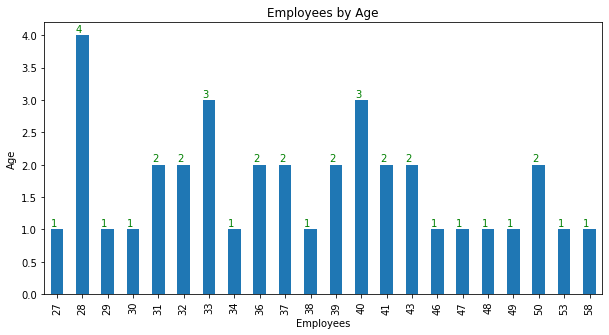

In [12]:
age_num = dataset.groupby(['Age']).agg({'ID.Worker': pd.Series.nunique})
ax = age_num.plot(kind='bar', figsize=(10,5), legend=False)
for i, v in enumerate(age_num.values):
    ax.text(i -0.25, v +0.05, str(v[0]), color='green')
ax.set_xlabel('Employees')
ax.set_ylabel('Age')
ax.set_title('Employees by Age')
plt.show()

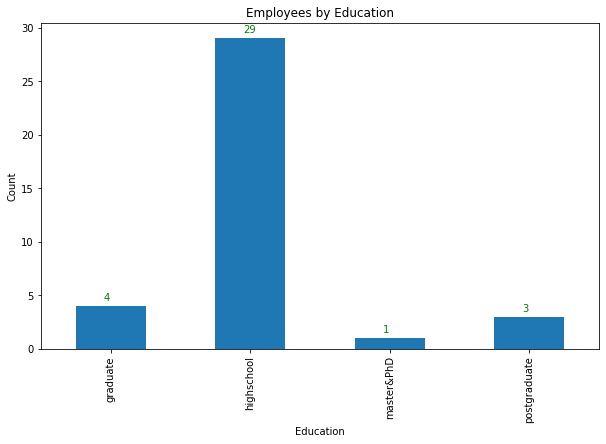

In [13]:
edu_num = dataset.groupby(['Education']).agg({'ID.Worker': pd.Series.nunique})
ax = edu_num.plot(kind='bar', figsize=(10,6), legend=False)
for i, v in enumerate(edu_num.values):
    ax.text(i-.05, v + 0.5, str(v[0]), color='green')
ax.set_xlabel('Education')
ax.set_ylabel('Count')
ax.set_title('Employees by Education')
plt.show()

The distribution of Age among the employees seems very heterogeneous. However, we can see that most of the employees in the company have a Highschool education level. We may find this information handy when going deep in the feature analysis on further steps.

Before doing the final preparations on the dataset for training a model, we will check for linear relationships between the features. We would expect to find high correlation among some of them, for example Body.mass.Index and Weight, Age and Service.Time, Distance.to.work and Transportation.Expense. We will use Pearson's correlation for the analysis and set a threshold of ~0.90 to remove features with a higher correlation:

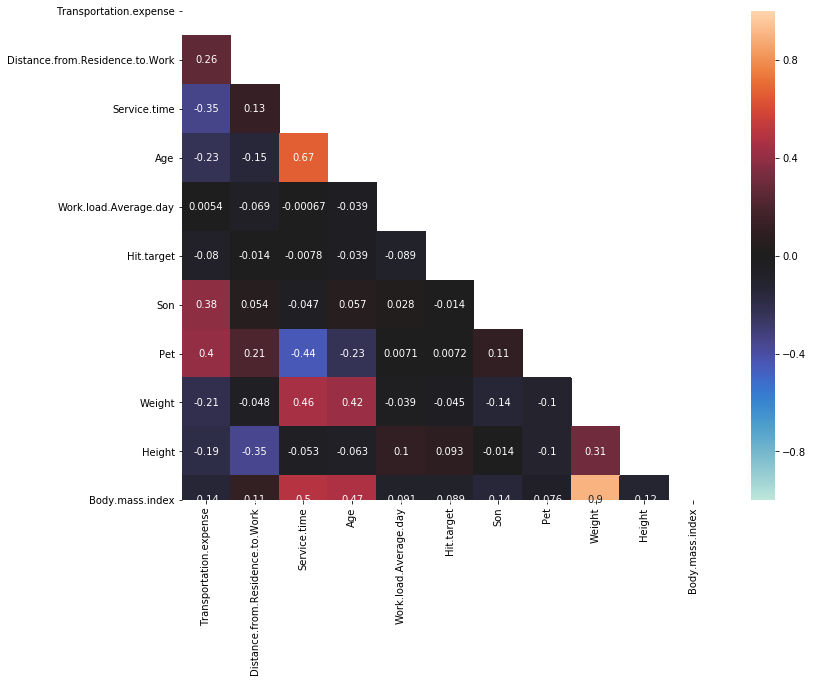

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

dataset_corr = dataset.corr()

# plot the Heatmap with Correlations in it

plt.figure(figsize=(12, 9))
mask = np.zeros_like(dataset_corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(dataset_corr, mask=mask, vmin=-1, vmax=1, center=0, annot=True)

In [15]:
corr1 = dataset['Body.mass.index'].corr(dataset['Weight'], method = 'pearson')
print("Correlation among Body.mass.Index and Weight is:", corr1)

Correlation among Body.mass.Index and Weight is: 0.9041169005730313


In [16]:
corr2 = dataset['Age'].corr(dataset['Service.time'], method = 'pearson')
print("Correlation among Age and Service.Time is:", corr2)

Correlation among Age and Service.Time is: 0.6709789169180516


As expected, we see high correlations between BMI and Weight, but not significantly high for Age and Service Time. After testing by removing both variables, we decide to remove Body.mass.index and keep the rest of the features, so that our model has less variables to analyze.

In [17]:
dataset.drop("Body.mass.index", inplace=True, axis=1)

Finally, since we have numerical and categorical values, we have to dummify the categorical features in the dataset so we can train our ML models. I will also standardize the numerical values:

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

categorical_cols = dataset.columns[dataset.dtypes=='category'].tolist()
categorical_cols.remove('Absenteeism') # Remove the target variable

# I do not want to include the ID or the ID of the worker
categorical_cols.remove('ID') 
categorical_cols.remove('ID.Worker')
numerical_cols = dataset.columns[dataset.dtypes!='category'].tolist()

ohe = OneHotEncoder()
std_scaler = StandardScaler()
mms = MinMaxScaler()

# Concat the numerical and dummified categorical columns
dummified_dataset = pd.concat([pd.DataFrame(mms.fit_transform(std_scaler.fit_transform(dataset[numerical_cols])), columns=numerical_cols).reset_index(drop=True),                    
                               pd.DataFrame(ohe.fit_transform(dataset[categorical_cols]).toarray(), columns=ohe.get_feature_names(categorical_cols)).reset_index(drop=True),
                               dataset['Absenteeism'].reset_index(drop=True)], axis=1)

In [19]:
dummified_dataset.head(5)

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height,Reason.for.absence_Certain conditions originating in the perinatal,...,Disciplinary.failure_0,Disciplinary.failure_1,Education_graduate,Education_highschool,Education_master&PhD,Education_postgraduate,Social.drinker_0,Social.drinker_1,Social.smoker_0,Social.smoker_1,Absenteeism
0,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
1,0.000000,0.170213,0.607143,0.741935,0.194471,0.842105,0.25,0.000,0.807692,0.454545,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
2,0.225926,0.978723,0.607143,0.354839,0.194471,0.842105,0.00,0.000,0.634615,0.212121,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0
3,0.596296,0.000000,0.464286,0.387097,0.194471,0.842105,0.50,0.000,0.230769,0.151515,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0
4,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


In [20]:
print("Number of rows:", len(dummified_dataset))
print("Number of cols:", len(dummified_dataset.columns))

Number of rows: 740
Number of cols: 71


Great, it is now formatted as it should. Let's start working with it. In order to have a baseline to compare the improvements introduced by the feature engineering process I am going to train a model with the dataset as it is. 

*Note in the function definition for the model that we are doing Cross Validation with K = 5 folds.

Accuracy = 0.8078


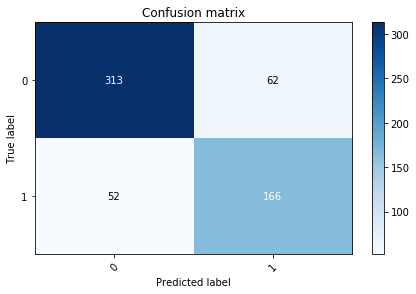

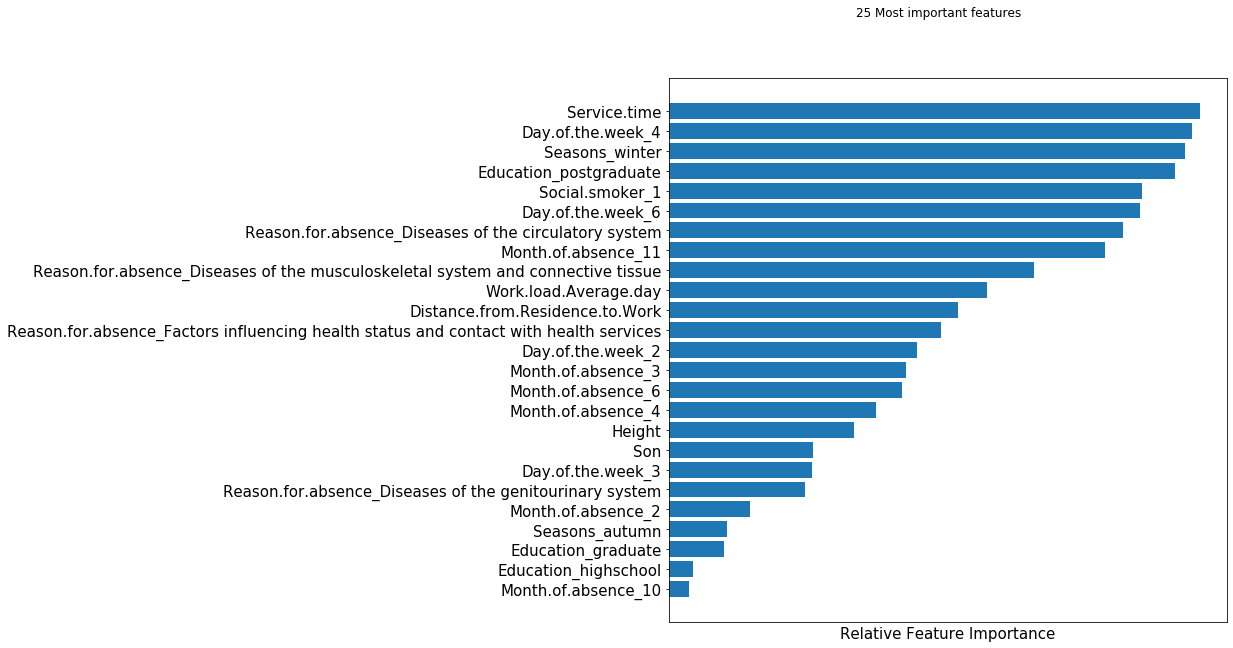

In [21]:
baseline_model, cross_val_score = train_model(dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1), dummified_dataset.iloc[0:593]['Absenteeism'], linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_fi=True)

In [22]:
results_df = pd.DataFrame(columns=['Approach', 'Accuracy'])
results_df.loc[len(results_df)] = ['LR Baseline', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757


Accuracy just below 81%, not a bad start. Let's see if we can improve it. To that end, we will study the  most important features in this baseline model. This will give us a first idea on the most important aspects in order to predict `Absenteeism`.


## Analyzing Outliers

We will now focus Outliers of Numerical values. Outliers can mislead the training of our models resulting in less accurate models and ultimately worse results. In this section we seek to identify outliers to then properly deal with them.

First, I will do a visual evaluation of the Min and Max values that seem to differ significantly from the Interquartile range, then I will analyze the BoxPlots. I am using the describe function, since by default it provides insights about the Numerical columns only. I have decided to do the visual analysis over the non-standardized dataframe (dataset), since the numeric values are more representative for Outliers and easier to interpret intuitively:

In [23]:
dataset.describe()

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,1.018919,0.745946,79.035135,172.114865
std,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,1.098489,1.318258,12.883211,6.034995
min,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,0.000000,56.000000,163.000000
25%,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,0.000000,69.000000,169.000000
50%,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,1.000000,0.000000,83.000000,170.000000
75%,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,2.000000,1.000000,89.000000,172.000000
max,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,4.000000,8.000000,108.000000,196.000000


Analyzing outliers of column: Transportation.expense
Analyzing outliers of column: Distance.from.Residence.to.Work
Analyzing outliers of column: Service.time
Analyzing outliers of column: Age
Analyzing outliers of column: Work.load.Average.day
Analyzing outliers of column: Hit.target
Analyzing outliers of column: Son
Analyzing outliers of column: Pet
Analyzing outliers of column: Weight
Analyzing outliers of column: Height


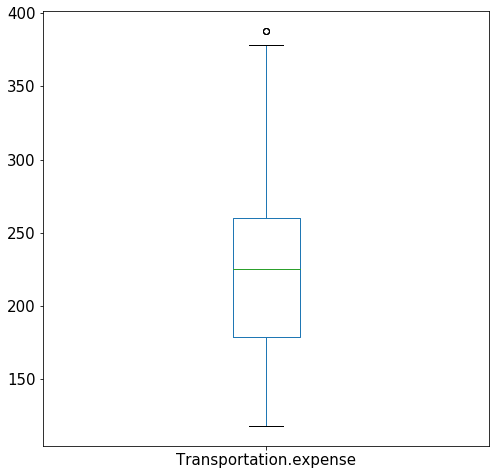

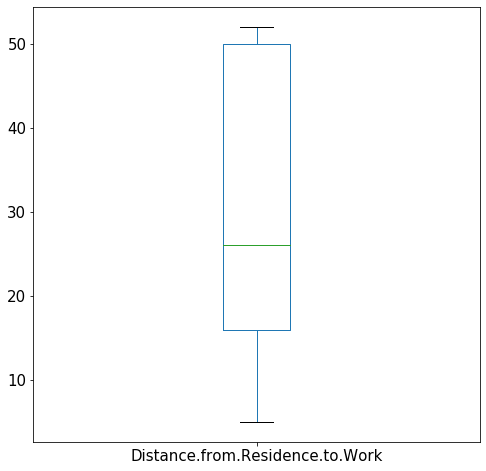

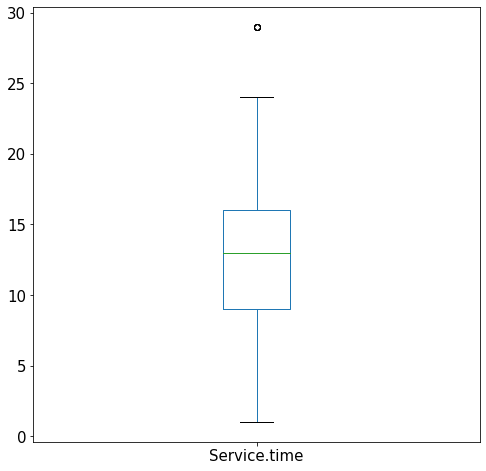

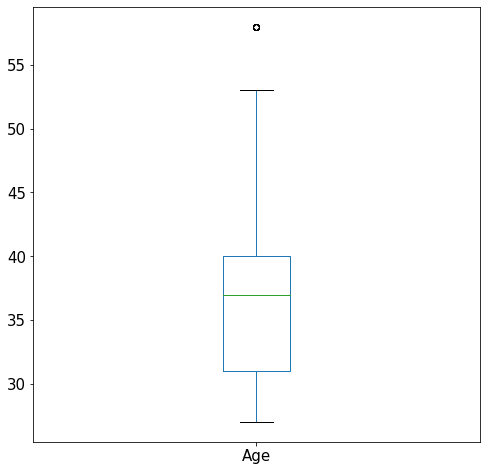

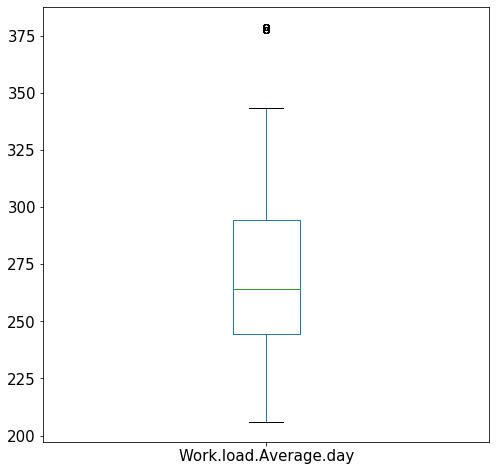

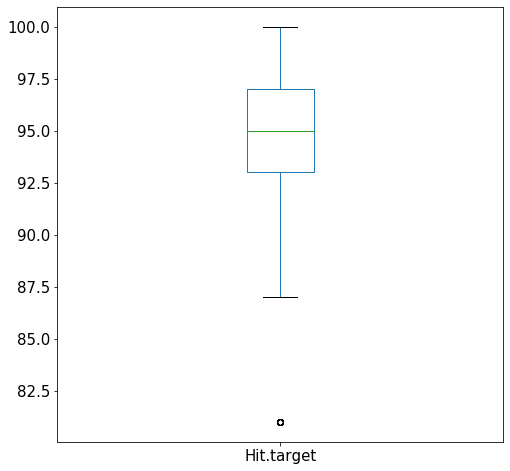

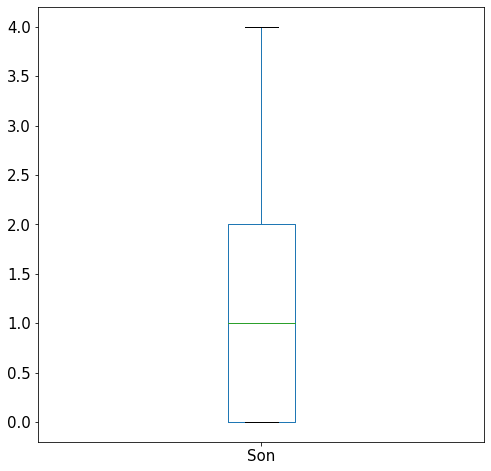

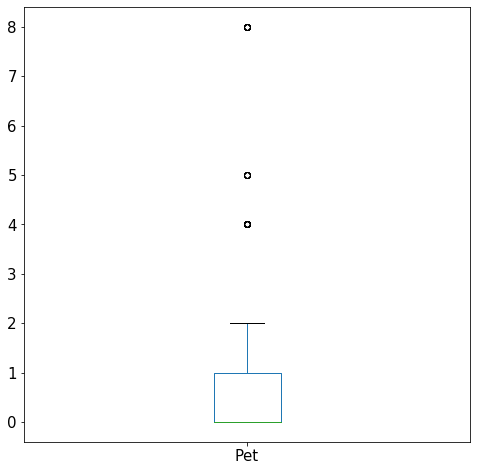

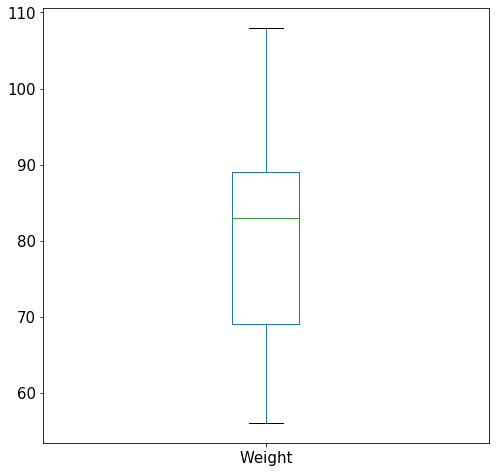

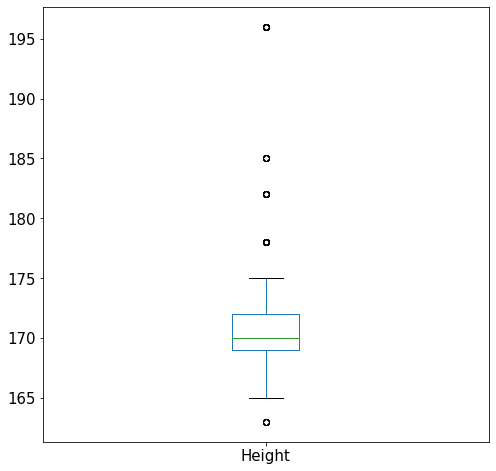

In [24]:
for (columnName, _) in dataset.iteritems():
    if dataset[columnName].dtype in ['int64','float64']: # IS numeric
        print("Analyzing outliers of column: {}".format(columnName))
        plt.figure(figsize=(8,8))
        dataset.boxplot([columnName], grid=False, fontsize=15)

After talking with our Business Owner, we have confirmed that the outliers are not errors and the data is correct. For this reason, we have decided not to remove them, since this may be useful information for the model (e.g. a very high average work load may have an impact on Absenteeism) and, considering that we are only working with the information of 36 employees we think it is best to find a way to make use of this information since we do not have that many datapoints. Addtionally, some of the Outliers are not significantly different from the values within the Interquartile range. 
We will try Binning instead.

# Feature Engineering

## Binning
Some of the numerical columns contain a couple of outliers and most of them have too many unique values to model effectively. We will create Bins for some of them, so that our trained model has less unnecessary values within variables to analyze and can come up with a better prediction.

In [25]:
# Renaming the Target variable as Yd, and the rest of the Variables as Xd, for simplicity when calling them from now on.
Xd = dummified_dataset.iloc[0:593].drop(['Absenteeism'],axis=1)
Yd = dummified_dataset.iloc[0:593]['Absenteeism']
Xd_test = dummified_dataset.iloc[593:len(dummified_dataset)].drop(['Absenteeism'],axis=1)

In [26]:
bin_dataset = dummified_dataset

In [27]:
bin_dataset['transport.expense.bin'] = pd.cut(bin_dataset['Transportation.expense'], bins=[0.0, 0.20, 0.30, 0.50, 0.70, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['distance.to.work.bin'] = pd.cut(bin_dataset['Distance.from.Residence.to.Work'], bins=[0.0, 0.20, 0.40, 0.50, 0.90, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['service.time.bin'] = pd.cut(bin_dataset['Service.time'], bins=[0.0, 0.25, 0.35, 0.50, 0.70, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['age.bin'] = pd.cut(bin_dataset['Age'], bins=[0.0, 0.10, 0.30, 0.45, 0.75, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['workload.day.bin'] = pd.cut(bin_dataset['Work.load.Average.day'], bins=[0.0, 0.10, 0.30, 0.45, 0.75, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['hit.target.bin'] = pd.cut(bin_dataset['Hit.target'], bins=[0.0, 0.40, 0.65, 0.80, 0.90, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['weight.bin'] = pd.cut(bin_dataset['Weight'], bins=[0.0, 0.20, 0.40, 0.60, 0.80, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')
bin_dataset['height.bin'] = pd.cut(bin_dataset['Height'], bins=[0.0, 0.10, 0.20, 0.30, 0.50, 1.0], labels=[0,1,2,3,4], include_lowest=True).astype('int64')

In [28]:
pd.options.display.max_columns = dataset.shape[1]
bin_dataset.head()

,Transportation.expense,Distance.from.Residence.to.Work,Service.time,Age,Work.load.Average.day,Hit.target,Son,Pet,Weight,Height,...,Social.smoker_1,Absenteeism,transport.expense.bin,distance.to.work.bin,service.time.bin,age.bin,workload.day.bin,hit.target.bin,weight.bin,height.bin
0,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,...,0.0,0,3,3,2,1,1,3,3,2
1,0.000000,0.170213,0.607143,0.741935,0.194471,0.842105,0.25,0.000,0.807692,0.454545,...,0.0,0,0,0,3,3,1,3,4,3
2,0.225926,0.978723,0.607143,0.354839,0.194471,0.842105,0.00,0.000,0.634615,0.212121,...,0.0,0,1,4,3,2,1,3,3,2
3,0.596296,0.000000,0.464286,0.387097,0.194471,0.842105,0.50,0.000,0.230769,0.151515,...,1.0,0,3,0,2,2,1,3,1,1
4,0.633333,0.659574,0.428571,0.193548,0.194471,0.842105,0.50,0.125,0.653846,0.272727,...,0.0,0,3,3,2,1,1,3,3,2


In [29]:
# Removing the original columns for the 8 features that have been Binned. Before removing them, we tested the model with all the binned and original
# variables, and found that the best performance is achieved by keeping only the Binned variables:
remove_columns = ["Transportation.expense","Distance.from.Residence.to.Work","Service.time","Age","Work.load.Average.day","Hit.target","Weight","Height"]
bin_dataset.drop(remove_columns, inplace=True, axis=1)

In [30]:
print("Number of rows:", len(bin_dataset))
print("Number of cols:", len(bin_dataset.columns))

Number of rows: 740
Number of cols: 71


*Saving a second version of the dataset through X and Y variables. We will test the models with both versions, the ones displayed in this report are the ones that performed better. Overall, the binned dataset performed better, with exception of the Information Gain model where the dummified (not-binned) model did better:*

In [31]:
X = bin_dataset.iloc[0:593].drop(['Absenteeism'],axis=1)
Y = bin_dataset.iloc[0:593]['Absenteeism']
X_test = bin_dataset.iloc[593:len(bin_dataset)].drop(['Absenteeism'],axis=1)

Just for information purposes, we will re-run our model to assess if the data cleaning and preparation process actually improves the Accuracy. We can see that it has already been slightly improved from 0.8078 to 0.8094 and that the most important reasons seem to be related to the month of the absence.

Accuracy = 0.8094


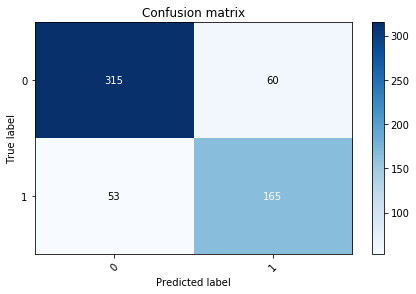

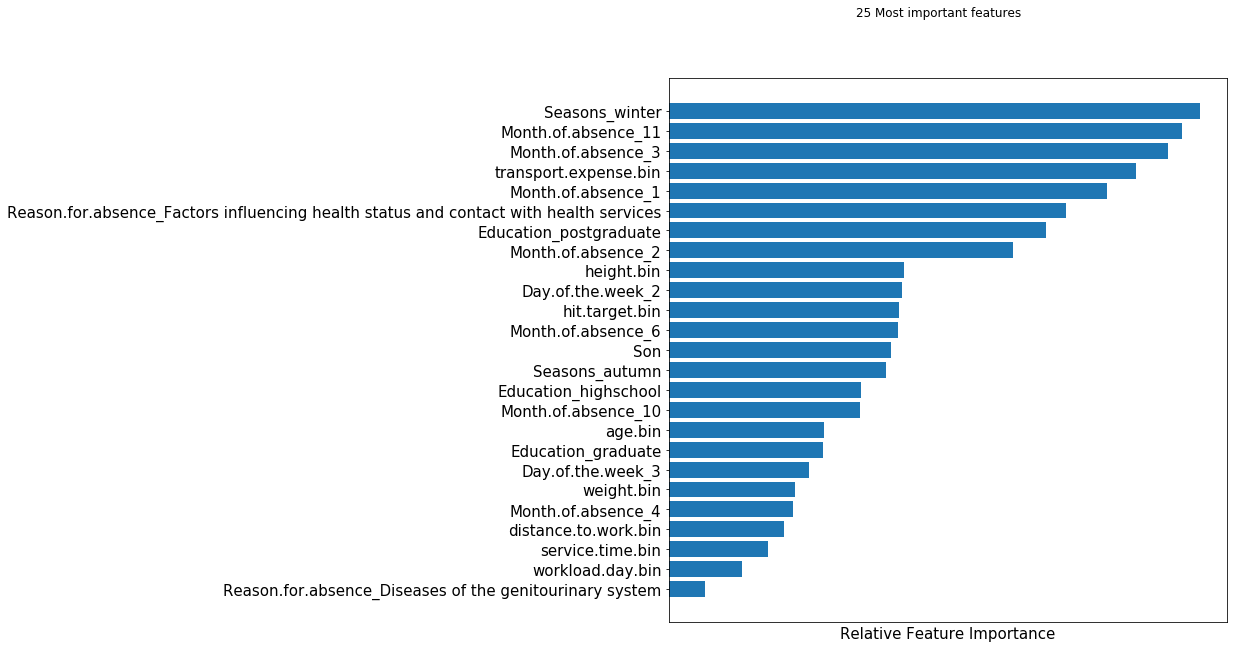

In [32]:
FE_Model, cross_val_score = train_model(X, Y, linear_model.LogisticRegression(max_iter=100000, penalty='none'), show_fi=True)

In [33]:
results_df.loc[len(results_df)] = ['FE_model', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,FE_model,0.809444


## Feature Selection

### Filtering Methods
We will rank the features based to their predictive power according to the methodologies: Chi Squared Independence test and the Information Gain.

#### Chi-squared Selection
We will measure the significance between features and the target variable (Absenteeism) by using the chi squared selection. Keeping only the feature combination that will help us reach the best possible performance.

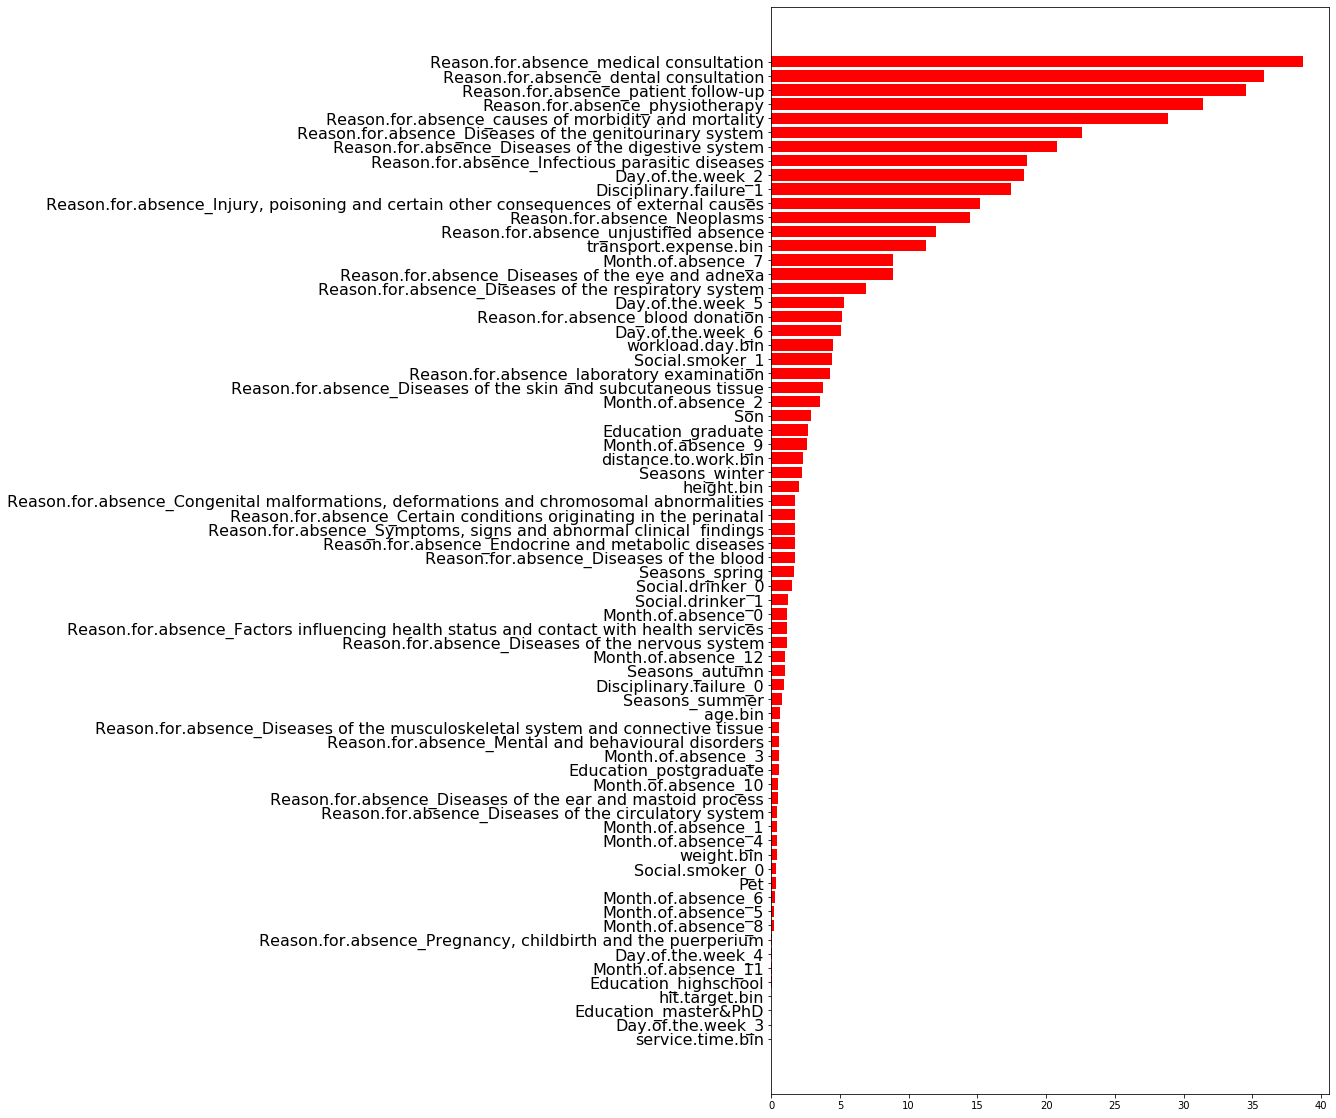

In [34]:
from sklearn.feature_selection import SelectKBest, chi2
chi2_selector = SelectKBest(score_func=chi2).fit(X,Y)

# Get the indices sorted by most important to least important
indices = np.argsort(chi2_selector.scores_)[::-1]

chi2_features = []
for i in range(len(X.columns)):
    chi2_features.append(X.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,20))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(chi2_features, chi2_selector.scores_[indices[range(len(X.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [35]:
for i in range(1,len(chi2_features)):
    print("Features used to train the model = {}".format(i))
    train_model(X[chi2_features[:i]], Y, linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_cm=False)

Features used to train the model = 1
Accuracy = 0.6324
Features used to train the model = 2
Accuracy = 0.6307
Features used to train the model = 3
Accuracy = 0.6273
Features used to train the model = 4
Accuracy = 0.7521
Features used to train the model = 5
Accuracy = 0.7521
Features used to train the model = 6
Accuracy = 0.7251
Features used to train the model = 7
Accuracy = 0.7133
Features used to train the model = 8
Accuracy = 0.8061
Features used to train the model = 9
Accuracy = 0.7858
Features used to train the model = 10
Accuracy = 0.7858
Features used to train the model = 11
Accuracy = 0.7858
Features used to train the model = 12
Accuracy = 0.8010
Features used to train the model = 13
Accuracy = 0.8280
Features used to train the model = 14
Accuracy = 0.8196
Features used to train the model = 15
Accuracy = 0.8212
Features used to train the model = 16
Accuracy = 0.8263
Features used to train the model = 17
Accuracy = 0.8347
Features used to train the model = 18
Accuracy = 0.8415
F

We can see that, according to the Chi-Squared test the optimal model is reached with 24 features. Lets see the most significant, train a model with those and evaluate its performance:

In [36]:
chi2_features[:24]

['Reason.for.absence_medical consultation',
 'Reason.for.absence_dental consultation',
 'Reason.for.absence_patient follow-up',
 'Reason.for.absence_physiotherapy',
 'Reason.for.absence_causes of morbidity and mortality',
 'Reason.for.absence_Diseases of the genitourinary system',
 'Reason.for.absence_Diseases of the digestive system',
 'Reason.for.absence_Infectious parasitic diseases',
 'Day.of.the.week_2',
 'Disciplinary.failure_1',
 'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
 'Reason.for.absence_Neoplasms',
 'Reason.for.absence_unjustified absence',
 'transport.expense.bin',
 'Month.of.absence_7',
 'Reason.for.absence_Diseases of the eye and adnexa',
 'Reason.for.absence_Diseases of the respiratory system',
 'Day.of.the.week_5',
 'Reason.for.absence_blood donation',
 'Day.of.the.week_6',
 'workload.day.bin',
 'Social.smoker_1',
 'Reason.for.absence_laboratory examination',
 'Reason.for.absence_Diseases of the skin and subcutaneous tiss

Accuracy = 0.8449


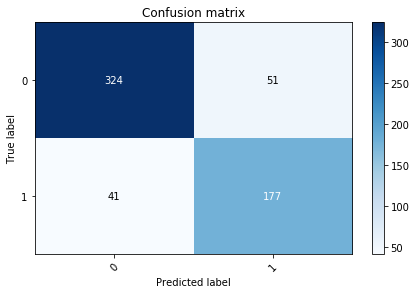

In [37]:
Chi2_model, cross_val_score = train_model(X[chi2_features[:24]], Y, linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_cm=True)

In [38]:
results_df.loc[len(results_df)] = ['Chi2_model', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,FE_model,0.809444
2,Chi2_model,0.844857


#### Information Gain Selection

We will now try the Information Gain Selection to compare the results. Main difference between these two tests, is that Information Gain takes into account the interaction between features, so we may get better results if there is an interaction that the previous test was not considering:

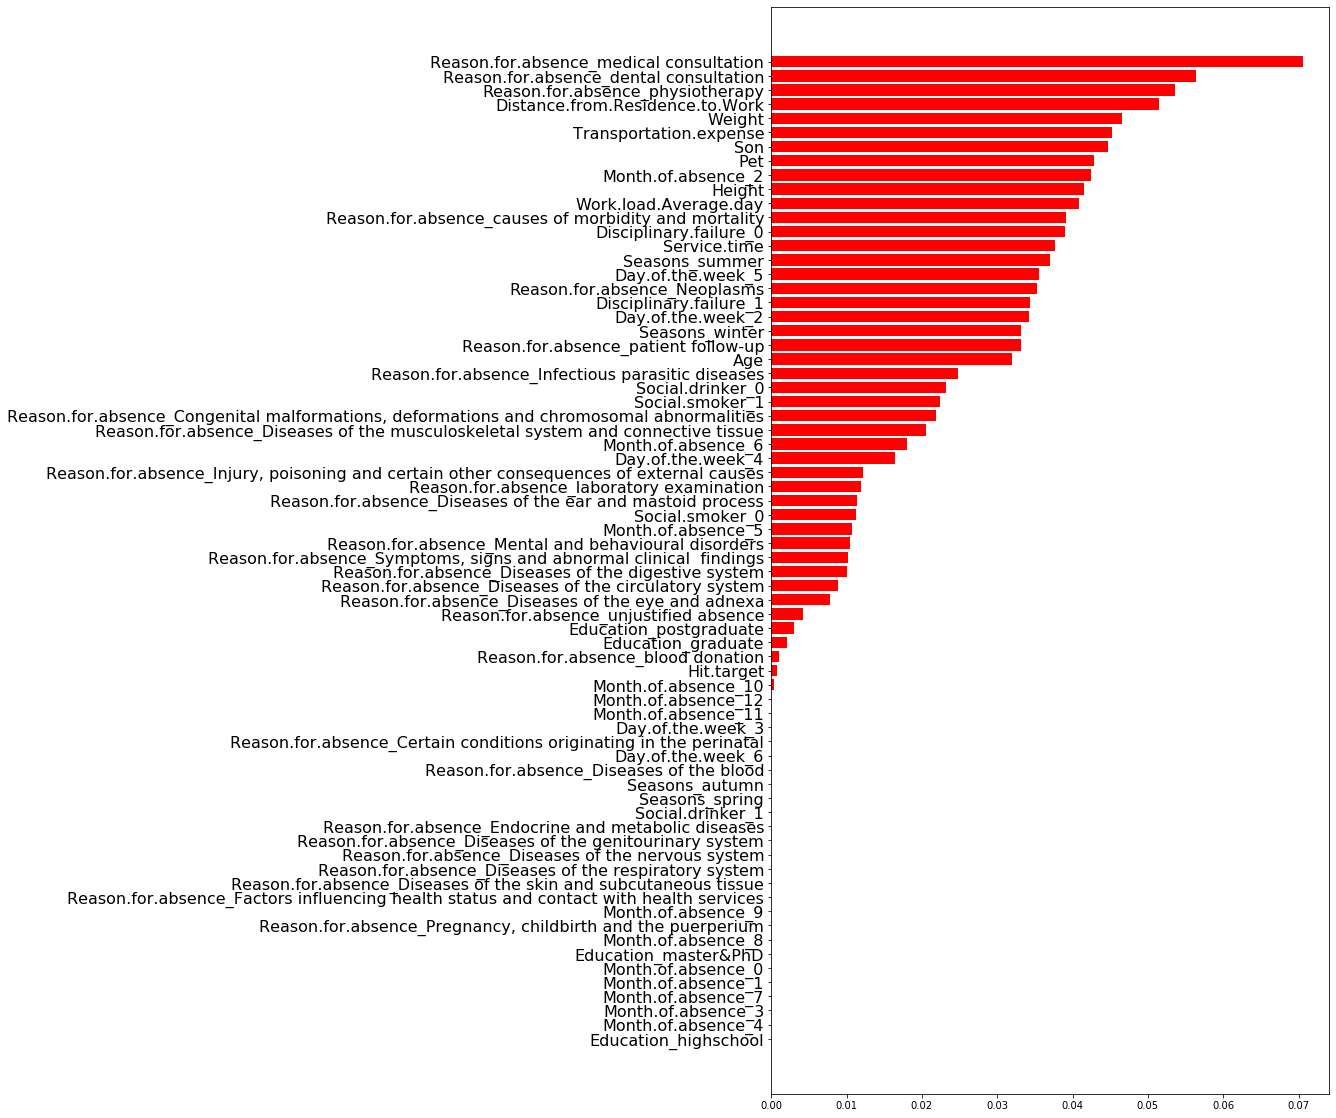

In [41]:
from sklearn.feature_selection import mutual_info_classif

ig_selector = SelectKBest(score_func=mutual_info_classif).fit(Xd,Yd)

# Get the indices sorted by most important to least important
indices = np.argsort(ig_selector.scores_)[::-1]

ig_features = []
for i in range(len(Xd.columns)):
    ig_features.append(Xd.columns[indices[i]])

# Now plot
plt.figure(figsize=(10,20))
plt.yticks(rotation='horizontal',fontsize=16)
plt.barh(ig_features, ig_selector.scores_[indices[range(len(Xd.columns))]], color='r', align='center')
plt.gca().invert_yaxis()
plt.show()

In [42]:
for i in range(1,len(ig_features)):
    print("Features used to train the model = {}".format(i))
    train_model(Xd[ig_features[:i]], Yd, linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_cm=False)

Features used to train the model = 1
Accuracy = 0.6324
Features used to train the model = 2
Accuracy = 0.6307
Features used to train the model = 3
Accuracy = 0.7521
Features used to train the model = 4
Accuracy = 0.7521
Features used to train the model = 5
Accuracy = 0.7521
Features used to train the model = 6
Accuracy = 0.7352
Features used to train the model = 7
Accuracy = 0.7437
Features used to train the model = 8
Accuracy = 0.7487
Features used to train the model = 9
Accuracy = 0.7420
Features used to train the model = 10
Accuracy = 0.7470
Features used to train the model = 11
Accuracy = 0.7403
Features used to train the model = 12
Accuracy = 0.7555
Features used to train the model = 13
Accuracy = 0.7943
Features used to train the model = 14
Accuracy = 0.7841
Features used to train the model = 15
Accuracy = 0.7892
Features used to train the model = 16
Accuracy = 0.7993
Features used to train the model = 17
Accuracy = 0.8010
Features used to train the model = 18
Accuracy = 0.8010
F

According to Information Gain the optimal model is reached with 31 features. Lets select the most significant, train a model and evaluate its performance:

In [43]:
ig_features[:31]

['Reason.for.absence_medical consultation',
 'Reason.for.absence_dental consultation',
 'Reason.for.absence_physiotherapy',
 'Distance.from.Residence.to.Work',
 'Weight',
 'Transportation.expense',
 'Son',
 'Pet',
 'Month.of.absence_2',
 'Height',
 'Work.load.Average.day',
 'Reason.for.absence_causes of morbidity and mortality',
 'Disciplinary.failure_0',
 'Service.time',
 'Seasons_summer',
 'Day.of.the.week_5',
 'Reason.for.absence_Neoplasms',
 'Disciplinary.failure_1',
 'Day.of.the.week_2',
 'Seasons_winter',
 'Reason.for.absence_patient follow-up',
 'Age',
 'Reason.for.absence_Infectious parasitic diseases',
 'Social.drinker_0',
 'Social.smoker_1',
 'Reason.for.absence_Congenital malformations, deformations and chromosomal abnormalities',
 'Reason.for.absence_Diseases of the musculoskeletal system and connective tissue',
 'Month.of.absence_6',
 'Day.of.the.week_4',
 'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
 'Reason.for.absence_laborat

Accuracy = 0.8246


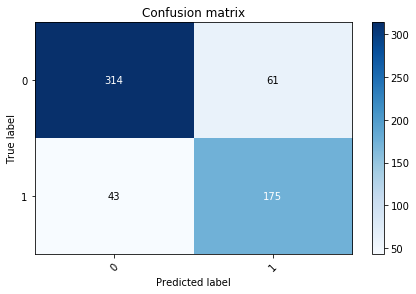

In [44]:
IG_model, cross_val_score = train_model(Xd[ig_features[:31]], Yd, linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_cm=True)

In [45]:
results_df.loc[len(results_df)] = ['IG_model', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,FE_model,0.809444
2,Chi2_model,0.844857
3,IG_model,0.824621


### Embedded

Finally, we will apply an embedded method to evaluate its performance and then create the final model. These are techniques that help us to improve the feature selection process by adding a penalty (l2) that will help us balance the trade off between Variance and Bias in our model.

#### Ridge





Accuracy = 0.8094


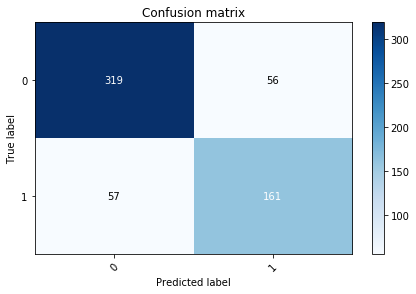

In [46]:
ridge_mod, cross_val_score = train_model(X, Y, linear_model.LogisticRegression(max_iter=10000, penalty='l2'), show_fi=False)

In [47]:
results_df.loc[len(results_df)] = ['LR_Ridge', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,FE_model,0.809444
2,Chi2_model,0.844857
3,IG_model,0.824621
4,LR_Ridge,0.809444


Lets do Cross Validation with different Alpha parameters and see if we can improve our Accuracy:

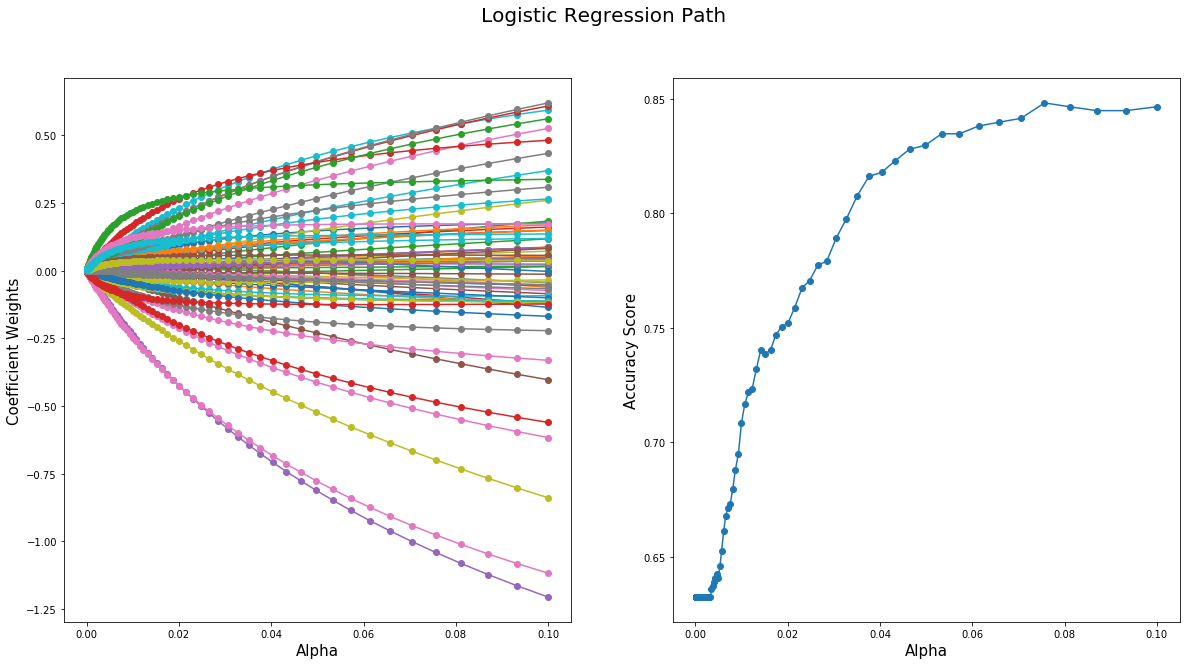

In [48]:
ridge_mod = linear_model.LogisticRegression(max_iter=10000,penalty='l2')
alphas = 10**np.linspace(-1,-4,100)

coefs_ = []
scores_ = []
for a in alphas:
    ridge_mod.set_params(C=a)
    ridge_mod.fit(X, Y)
    coefs_.append(ridge_mod.coef_.ravel().copy())
    scores_.append(accuracy_score(Y,ridge_mod.predict(X)))

coefs_ = np.array(coefs_)
scores_ = np.array(scores_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
fig.suptitle('Logistic Regression Path', fontsize=20)

# Coeff Weights Plot
ax1.plot(alphas, coefs_, marker='o')
ymin, ymax = plt.ylim()
ax1.set_ylabel('Coefficient Weights', fontsize = 15)
ax1.set_xlabel('Alpha', fontsize = 15)
ax1.axis('tight')

# Accuracy Plot
ax2.plot(alphas, scores_, marker='o')
ymin, ymax = plt.ylim()
ax2.set_ylabel('Accuracy Score', fontsize = 15)
ax2.set_xlabel('Alpha', fontsize = 15)
ax2.axis('tight')

plt.show()

In [49]:
alphas = 10**np.linspace(0.5,1,100)

In [50]:
from sklearn.feature_selection import SelectFromModel

Ridge_mod_cv = linear_model.LogisticRegressionCV(max_iter=10000,penalty='l2',Cs=alphas).fit(X, Y)

Accuracy = 0.8162


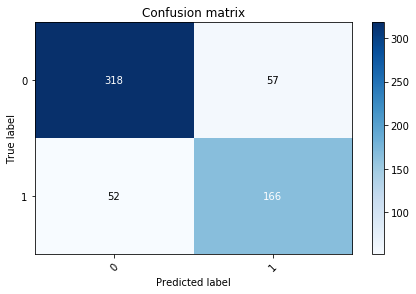

In [51]:
Ridge_modCV, cross_val_score = train_model(X, Y, Ridge_mod_cv)

In [52]:
results_df.loc[len(results_df)] = ['Ridge_modCV', cross_val_score]
results_df

,Approach,Accuracy
0,LR Baseline,0.807757
1,FE_model,0.809444
2,Chi2_model,0.844857
3,IG_model,0.824621
4,LR_Ridge,0.809444
5,Ridge_modCV,0.816189


Our top performing model comes from the Chi-Square feature selection:

In [53]:
X_train = X[chi2_features[:24]]
X_test = X_test[chi2_features[:24]]

These is the final list of the 24 top features that we will use to predict Absenteeism. As we can see the most important variable is "Reason for Absence", which makes sense: the main reason why an employee is absent is because he / she has a medical condition. 

In [54]:
X_train.columns

Index(['Reason.for.absence_medical consultation',
       'Reason.for.absence_dental consultation',
       'Reason.for.absence_patient follow-up',
       'Reason.for.absence_physiotherapy',
       'Reason.for.absence_causes of morbidity and mortality',
       'Reason.for.absence_Diseases of the genitourinary system',
       'Reason.for.absence_Diseases of the digestive system',
       'Reason.for.absence_Infectious parasitic diseases', 'Day.of.the.week_2',
       'Disciplinary.failure_1',
       'Reason.for.absence_Injury, poisoning and certain other consequences of external causes',
       'Reason.for.absence_Neoplasms',
       'Reason.for.absence_unjustified absence', 'transport.expense.bin',
       'Month.of.absence_7',
       'Reason.for.absence_Diseases of the eye and adnexa',
       'Reason.for.absence_Diseases of the respiratory system',
       'Day.of.the.week_5', 'Reason.for.absence_blood donation',
       'Day.of.the.week_6', 'workload.day.bin', 'Social.smoker_1',
       'Reas

### Final version of the model that could be implemented in production, after validating the performance with the Test set:

Accuracy = 0.8449


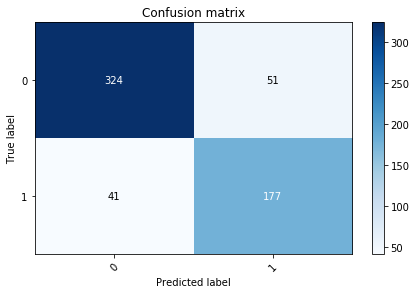

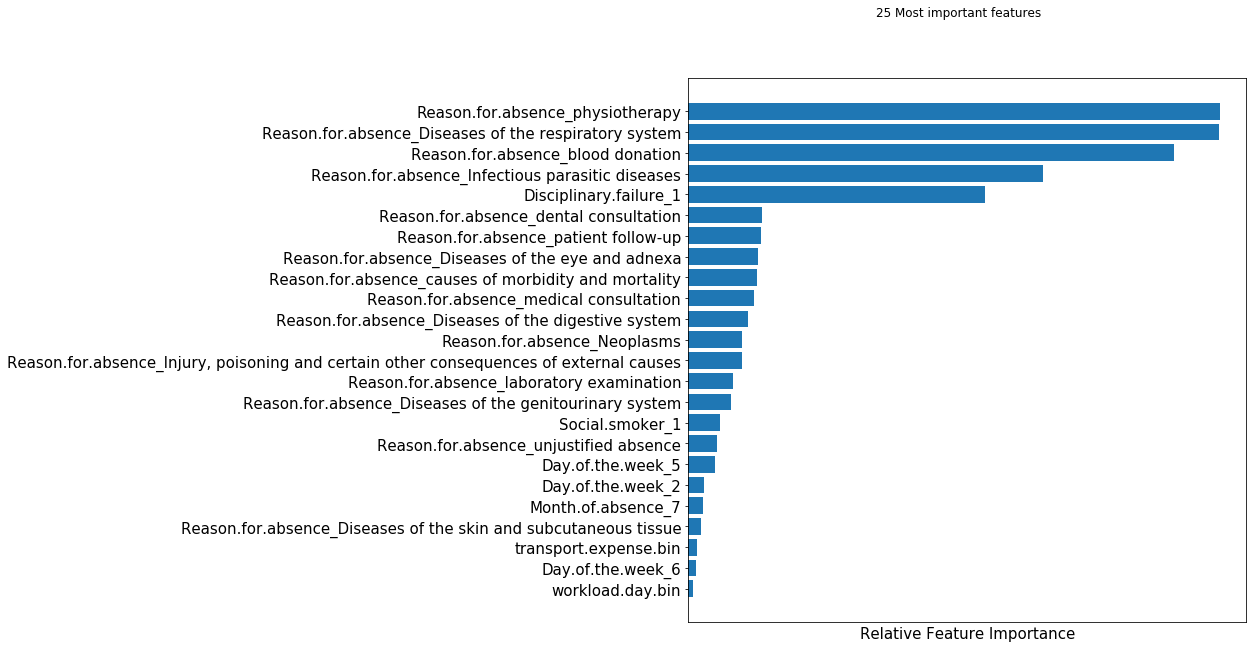

In [55]:
Chi2_model, score = train_model(X_train, Y, linear_model.LogisticRegression(max_iter=10000, penalty='none'), show_fi=True)

# Final Deliverable

The following piece of code will generate the prediction file with the format that has been required by the Business Owner (a column with the `ID` and a column with the predictions `"Absenteeism`).

Accuracy = 0.8449


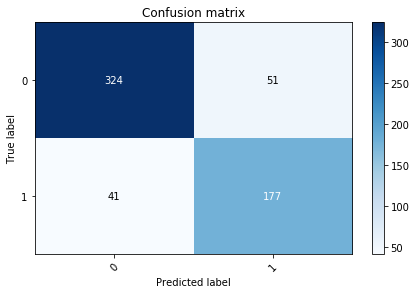

In [56]:
# Train the model using all the data
final_model, final_cross_val_score = train_model(X_train, Y, linear_model.LogisticRegression(max_iter=10000, penalty='none'))

# Test prediction
final_pred = final_model.predict(X_test)
predictions = pd.DataFrame({'ID':test['ID'], 'Absenteeism.time.in.hours':final_pred})
predictions.to_csv("predictions.csv", index=False)